### 重新整理数据

In [5]:
import os
import shutil
import random
from collections import defaultdict

def merge_data(source_dir, target_dir):
    """
    合并train和val数据集到新目录
    :param source_dir: 原始数据集根目录 (包含train/和val/)
    :param target_dir: 合并后的目标目录
    """
    # 创建目标目录结构
    os.makedirs(os.path.join(target_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'labels'), exist_ok=True)
    
    # 处理训练集
    for split in ['train', 'val']:
        img_source = os.path.join(source_dir, split, 'images')
        lbl_source = os.path.join(source_dir, split, 'labels')
        
        # 复制图片
        for img_file in os.listdir(img_source):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                src_path = os.path.join(img_source, img_file)
                dst_path = os.path.join(target_dir, 'images', img_file)
                
                # 处理文件名冲突
                counter = 1
                while os.path.exists(dst_path):
                    name, ext = os.path.splitext(img_file)
                    dst_path = os.path.join(target_dir, 'images', f"{name}_{split}_{counter}{ext}")
                    counter += 1
                
                shutil.copy2(src_path, dst_path)
                
                # 复制对应的标签文件
                lbl_file = os.path.splitext(img_file)[0] + '.txt'
                src_lbl = os.path.join(lbl_source, lbl_file)
                dst_lbl = os.path.join(target_dir, 'labels', os.path.basename(dst_path).rsplit('.', 1)[0] + '.txt')
                
                if os.path.exists(src_lbl):
                    shutil.copy2(src_lbl, dst_lbl)

def split_data(merged_dir, output_dir, val_ratio=0.2, min_val_samples=1):
    """
    重新划分数据集，确保每个类别在训练集和验证集中都有样本
    :param merged_dir: 合并后的数据集目录
    :param output_dir: 输出目录
    :param val_ratio: 验证集比例
    :param min_val_samples: 每个类别在验证集中的最小样本数
    """
    # 创建输出目录
    train_img_dir = os.path.join(output_dir, 'train', 'images')
    train_lbl_dir = os.path.join(output_dir, 'train', 'labels')
    val_img_dir = os.path.join(output_dir, 'val', 'images')
    val_lbl_dir = os.path.join(output_dir, 'val', 'labels')
    
    for d in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir]:
        os.makedirs(d, exist_ok=True)
    
    # 收集所有图像文件
    image_files = [f for f in os.listdir(os.path.join(merged_dir, 'images')) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_files)
    
    # 类别到图像的映射
    class_to_images = defaultdict(list)
    # 图像到类别的映射
    image_to_classes = {}
    
    # 第一遍扫描：收集类别信息
    for img_file in image_files:
        img_name = os.path.splitext(img_file)[0]
        lbl_file = os.path.join(merged_dir, 'labels', img_name + '.txt')
        
        if not os.path.exists(lbl_file):
            continue
            
        with open(lbl_file, 'r') as f:
            lines = f.readlines()
        
        classes_in_image = set()
        for line in lines:
            if line.strip():
                class_id = int(line.split()[0])
                classes_in_image.add(class_id)
                class_to_images[class_id].append(img_file)
        
        image_to_classes[img_file] = classes_in_image
    
    # 确保每个类别在验证集中有足够的样本
    val_set = set()
    
    # 为每个类别分配验证样本
    for class_id, images in class_to_images.items():
        # 过滤掉已经被选中的图像
        available = [img for img in images if img not in val_set]
        if not available:
            continue
            
        # 确保每个类别至少有min_val_samples个验证样本
        n_samples = min(min_val_samples, len(available))
        selected = random.sample(available, n_samples)
        val_set.update(selected)
    
    # 计算需要的验证集总数
    total_val_needed = int(len(image_files) * val_ratio)
    
    # 如果当前验证集不足，补充随机样本
    if len(val_set) < total_val_needed:
        remaining = [img for img in image_files if img not in val_set]
        additional_needed = total_val_needed - len(val_set)
        if additional_needed > len(remaining):
            additional_needed = len(remaining)
        
        val_set.update(random.sample(remaining, additional_needed))
    
    # 划分数据集
    for img_file in image_files:
        src_img = os.path.join(merged_dir, 'images', img_file)
        img_name = os.path.splitext(img_file)[0]
        src_lbl = os.path.join(merged_dir, 'labels', img_name + '.txt')
        
        if img_file in val_set:  # 验证集
            dst_img = os.path.join(val_img_dir, img_file)
            dst_lbl = os.path.join(val_lbl_dir, img_name + '.txt')
        else:  # 训练集
            dst_img = os.path.join(train_img_dir, img_file)
            dst_lbl = os.path.join(train_lbl_dir, img_name + '.txt')
        
        shutil.copy2(src_img, dst_img)
        if os.path.exists(src_lbl):
            shutil.copy2(src_lbl, dst_lbl)
    
    # 验证类别覆盖情况
    verify_class_coverage(val_lbl_dir, class_to_images.keys(), "Validation")
    verify_class_coverage(train_lbl_dir, class_to_images.keys(), "Training")

def verify_class_coverage(label_dir, all_classes, set_name):
    """验证数据集中的类别覆盖情况"""
    found_classes = set()
    for lbl_file in os.listdir(label_dir):
        if lbl_file.endswith('.txt'):
            with open(os.path.join(label_dir, lbl_file), 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])
                        found_classes.add(class_id)
    
    missing = all_classes - found_classes
    if missing:
        print(f"⚠️ Warning: {set_name} set missing classes: {sorted(missing)}")
    else:
        print(f"✅ {set_name} set contains all {len(all_classes)} classes")

if __name__ == "__main__":
    # 配置路径
    SOURCE_DIR = "../data/12_RGB_ObjDet_640_fL"        # 原始数据集根目录
    MERGED_DIR = "../data/12_RGB_ObjDet_640_fL/treeai_merged" # 合并后的目录
    OUTPUT_DIR = "../data/12_RGB_ObjDet_640_fL/treeai_split"  # 重新划分后的目录
    
    # 执行合并
    print("Merging datasets...")
    merge_data(SOURCE_DIR, MERGED_DIR)
    print(f"Data merged to {MERGED_DIR}")
    
    # 执行重新划分
    print("\nSplitting dataset with balanced classes...")
    split_data(MERGED_DIR, OUTPUT_DIR, val_ratio=0.2)
    print(f"New dataset created at {OUTPUT_DIR}")
    print("\nDirectory structure:")
    print(f"{OUTPUT_DIR}")
    print("├── train")
    print("│   ├── images")
    print("│   └── labels")
    print("└── val")
    print("    ├── images")
    print("    └── labels")

Merging datasets...
Data merged to ../data/12_RGB_ObjDet_640_fL/treeai_merged

Splitting dataset with balanced classes...
✅ Validation set contains all 53 classes
✅ Training set contains all 53 classes
New dataset created at ../data/12_RGB_ObjDet_640_fL/treeai_split

Directory structure:
../data/12_RGB_ObjDet_640_fL/treeai_split
├── train
│   ├── images
│   └── labels
└── val
    ├── images
    └── labels


### 验证数据集的类别覆盖情况

训练集类别分布:
  类别 1: 11065 个样本
  类别 2: 10297 个样本
  类别 3: 4579 个样本
  类别 4: 4765 个样本
  类别 5: 2240 个样本
  类别 6: 2305 个样本
  类别 7: 2014 个样本
  类别 8: 1465 个样本
  类别 9: 1446 个样本
  类别 10: 1379 个样本
  类别 11: 1288 个样本
  类别 12: 1015 个样本
  类别 13: 1240 个样本
  类别 14: 868 个样本
  类别 15: 785 个样本
  类别 16: 493 个样本
  类别 17: 541 个样本
  类别 18: 207 个样本
  类别 19: 553 个样本
  类别 20: 476 个样本
  类别 21: 280 个样本
  类别 22: 297 个样本
  类别 23: 247 个样本
  类别 24: 277 个样本
  类别 25: 257 个样本
  类别 26: 298 个样本
  类别 27: 225 个样本
  类别 28: 244 个样本
  类别 29: 249 个样本
  类别 30: 170 个样本
  类别 31: 188 个样本
  类别 32: 236 个样本
  类别 33: 142 个样本
  类别 34: 130 个样本
  类别 35: 108 个样本
  类别 36: 122 个样本
  类别 37: 150 个样本
  类别 38: 137 个样本
  类别 39: 129 个样本
  类别 40: 98 个样本
  类别 41: 63 个样本
  类别 42: 47 个样本
  类别 43: 34 个样本
  类别 44: 51 个样本
  类别 45: 74 个样本
  类别 46: 66 个样本
  类别 47: 70 个样本
  类别 48: 36 个样本
  类别 49: 54 个样本
  类别 50: 218 个样本
  类别 51: 32 个样本
  类别 52: 70 个样本
  类别 53: 44 个样本

验证集类别分布:
  类别 1: 2825 个样本
  类别 2: 2920 个样本
  类别 3: 1232 个样本
  类别 4: 1186 个样本
  类别 5: 610 个样本
  类

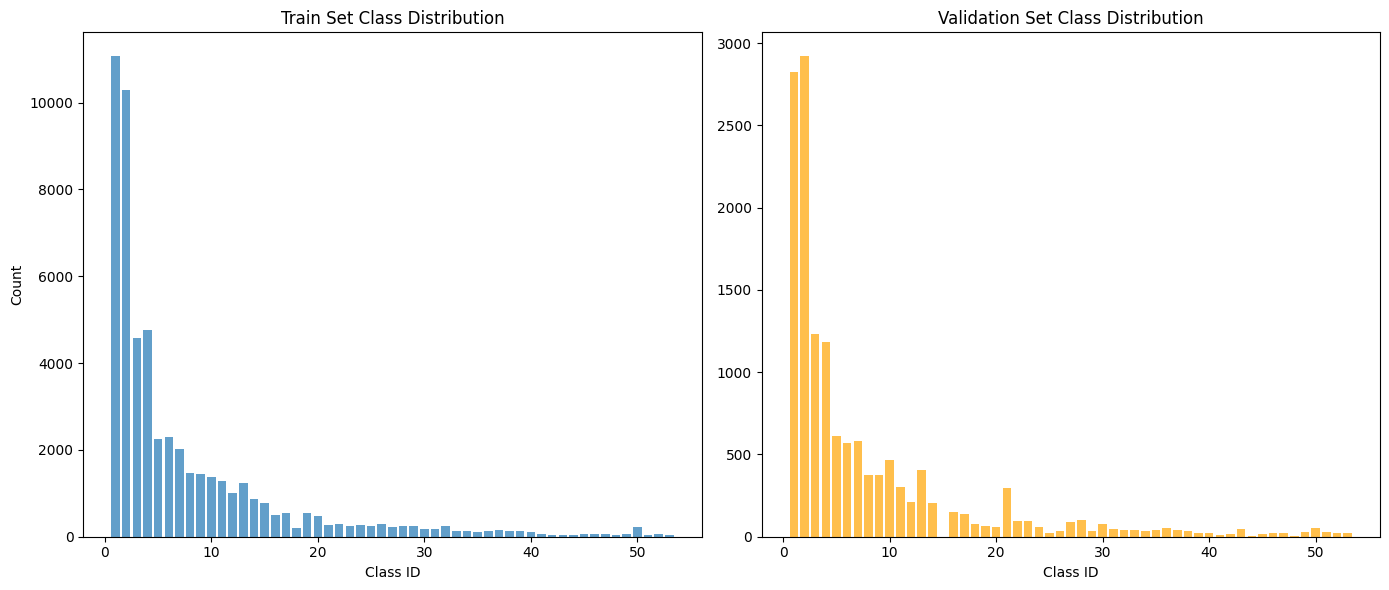


各类别样本比例(训练集/验证集):
  类别 1: 11065 / 2825 ≈ 3.9:1
  类别 2: 10297 / 2920 ≈ 3.5:1
  类别 3: 4579 / 1232 ≈ 3.7:1
  类别 4: 4765 / 1186 ≈ 4.0:1
  类别 5: 2240 / 610 ≈ 3.7:1
  类别 6: 2305 / 570 ≈ 4.0:1
  类别 7: 2014 / 579 ≈ 3.5:1
  类别 8: 1465 / 376 ≈ 3.9:1
  类别 9: 1446 / 377 ≈ 3.8:1
  类别 10: 1379 / 467 ≈ 3.0:1
  类别 11: 1288 / 304 ≈ 4.2:1
  类别 12: 1015 / 210 ≈ 4.8:1
  类别 13: 1240 / 406 ≈ 3.1:1
  类别 14: 868 / 202 ≈ 4.3:1
  类别 15: 785 / 0 ≈ ∞ (验证集无样本)
  类别 16: 493 / 152 ≈ 3.2:1
  类别 17: 541 / 137 ≈ 3.9:1
  类别 18: 207 / 75 ≈ 2.8:1
  类别 19: 553 / 63 ≈ 8.8:1
  类别 20: 476 / 58 ≈ 8.2:1
  类别 21: 280 / 295 ≈ 0.9:1
  类别 22: 297 / 98 ≈ 3.0:1
  类别 23: 247 / 94 ≈ 2.6:1
  类别 24: 277 / 58 ≈ 4.8:1
  类别 25: 257 / 21 ≈ 12.2:1
  类别 26: 298 / 34 ≈ 8.8:1
  类别 27: 225 / 89 ≈ 2.5:1
  类别 28: 244 / 102 ≈ 2.4:1
  类别 29: 249 / 32 ≈ 7.8:1
  类别 30: 170 / 77 ≈ 2.2:1
  类别 31: 188 / 45 ≈ 4.2:1
  类别 32: 236 / 39 ≈ 6.1:1
  类别 33: 142 / 40 ≈ 3.5:1
  类别 34: 130 / 37 ≈ 3.5:1
  类别 35: 108 / 43 ≈ 2.5:1
  类别 36: 122 / 50 ≈ 2.4:1
  类别 37: 150

In [4]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

def count_classes(label_dir):
    """统计YOLO标签文件夹中的类别分布"""
    class_counts = defaultdict(int)
    for filename in os.listdir(label_dir):
        if not filename.endswith('.txt'):
            continue
        with open(os.path.join(label_dir, filename), 'r') as f:
            for line in f:
                if line.strip():  # 跳过空行
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
    return dict(sorted(class_counts.items()))

# 路径设置
train_label_dir = '../data/12_RGB_ObjDet_640_fL/train/labels'
val_label_dir = '../data/12_RGB_ObjDet_640_fL/val/labels'

# 统计类别
train_counts = count_classes(train_label_dir)
val_counts = count_classes(val_label_dir)

# 获取所有可能的类别ID
all_classes = set(train_counts.keys()).union(set(val_counts.keys()))

# 打印完整统计结果
print("训练集类别分布:")
for cls, count in sorted(train_counts.items()):
    print(f"  类别 {cls}: {count} 个样本")

print("\n验证集类别分布:")
for cls, count in sorted(val_counts.items()):
    print(f"  类别 {cls}: {count} 个样本")

# 检查类别差异
train_only = set(train_counts.keys()) - set(val_counts.keys())
val_only = set(val_counts.keys()) - set(train_counts.keys())

print("\n类别分布差异:")
if train_only:
    print(f"  ⚠️ 仅在训练集中出现的类别: {sorted(train_only)}")
else:
    print("  ✅ 没有仅在训练集中出现的类别")

if val_only:
    print(f"  ⚠️ 仅在验证集中出现的类别: {sorted(val_only)}")
else:
    print("  ✅ 没有仅在验证集中出现的类别")

# 检查是否所有类别在两个集合中都存在
if not train_only and not val_only:
    print("\n✅ 训练集和验证集包含完全相同的类别")
else:
    print("\n❌ 警告: 训练集和验证集类别不完全一致")

# 可视化比较
plt.figure(figsize=(14, 6))

# 训练集分布
plt.subplot(1, 2, 1)
plt.bar(train_counts.keys(), train_counts.values(), alpha=0.7, label='Train')
plt.title('Train Set Class Distribution')
plt.xlabel('Class ID')
plt.ylabel('Count')

# 验证集分布
plt.subplot(1, 2, 2)
plt.bar(val_counts.keys(), val_counts.values(), alpha=0.7, color='orange', label='Val')
plt.title('Validation Set Class Distribution')
plt.xlabel('Class ID')

plt.tight_layout()
plt.show()

# 打印类别比例差异
print("\n各类别样本比例(训练集/验证集):")
for cls in sorted(all_classes):
    train_num = train_counts.get(cls, 0)
    val_num = val_counts.get(cls, 0)
    ratio = f"{train_num/val_num:.1f}:1" if val_num != 0 else "∞ (验证集无样本)"
    print(f"  类别 {cls}: {train_num} / {val_num} ≈ {ratio}")

训练集类别分布:
  类别 1: 11379 个样本
  类别 2: 10704 个样本
  类别 3: 4686 个样本
  类别 4: 4723 个样本
  类别 5: 2364 个样本
  类别 6: 2366 个样本
  类别 7: 2115 个样本
  类别 8: 1487 个样本
  类别 9: 1465 个样本
  类别 10: 1557 个样本
  类别 11: 1346 个样本
  类别 12: 942 个样本
  类别 13: 1426 个样本
  类别 14: 879 个样本
  类别 15: 487 个样本
  类别 16: 532 个样本
  类别 17: 511 个样本
  类别 18: 229 个样本
  类别 19: 469 个样本
  类别 20: 433 个样本
  类别 21: 436 个样本
  类别 22: 348 个样本
  类别 23: 244 个样本
  类别 24: 241 个样本
  类别 25: 242 个样本
  类别 26: 242 个样本
  类别 27: 232 个样本
  类别 28: 249 个样本
  类别 29: 185 个样本
  类别 30: 189 个样本
  类别 31: 170 个样本
  类别 32: 228 个样本
  类别 33: 154 个样本
  类别 34: 151 个样本
  类别 35: 108 个样本
  类别 36: 133 个样本
  类别 37: 88 个样本
  类别 38: 137 个样本
  类别 39: 126 个样本
  类别 40: 86 个样本
  类别 41: 49 个样本
  类别 42: 39 个样本
  类别 43: 67 个样本
  类别 44: 44 个样本
  类别 45: 50 个样本
  类别 46: 63 个样本
  类别 47: 60 个样本
  类别 48: 33 个样本
  类别 49: 63 个样本
  类别 50: 174 个样本
  类别 51: 41 个样本
  类别 52: 67 个样本
  类别 53: 42 个样本

验证集类别分布:
  类别 1: 2511 个样本
  类别 2: 2513 个样本
  类别 3: 1125 个样本
  类别 4: 1228 个样本
  类别 5: 486 个样本
  类别 

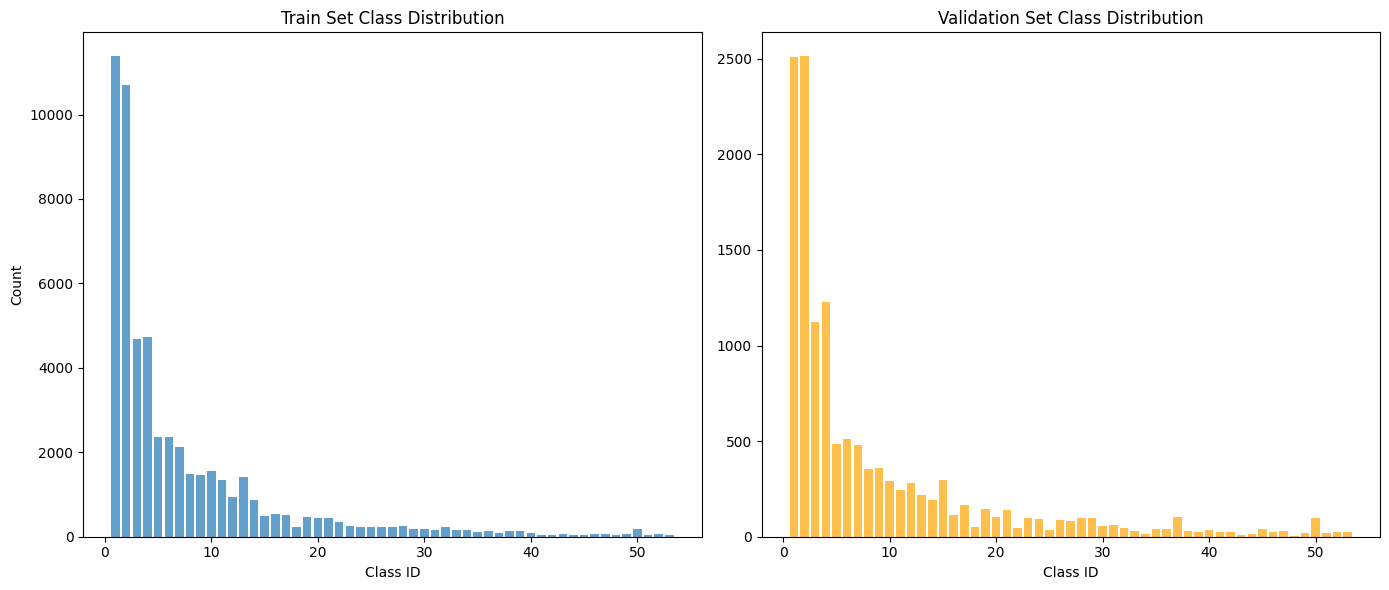


各类别样本比例(训练集/验证集):
  类别 1: 11379 / 2511 ≈ 4.5:1
  类别 2: 10704 / 2513 ≈ 4.3:1
  类别 3: 4686 / 1125 ≈ 4.2:1
  类别 4: 4723 / 1228 ≈ 3.8:1
  类别 5: 2364 / 486 ≈ 4.9:1
  类别 6: 2366 / 509 ≈ 4.6:1
  类别 7: 2115 / 478 ≈ 4.4:1
  类别 8: 1487 / 354 ≈ 4.2:1
  类别 9: 1465 / 358 ≈ 4.1:1
  类别 10: 1557 / 289 ≈ 5.4:1
  类别 11: 1346 / 246 ≈ 5.5:1
  类别 12: 942 / 283 ≈ 3.3:1
  类别 13: 1426 / 220 ≈ 6.5:1
  类别 14: 879 / 191 ≈ 4.6:1
  类别 15: 487 / 298 ≈ 1.6:1
  类别 16: 532 / 113 ≈ 4.7:1
  类别 17: 511 / 167 ≈ 3.1:1
  类别 18: 229 / 53 ≈ 4.3:1
  类别 19: 469 / 147 ≈ 3.2:1
  类别 20: 433 / 101 ≈ 4.3:1
  类别 21: 436 / 139 ≈ 3.1:1
  类别 22: 348 / 47 ≈ 7.4:1
  类别 23: 244 / 97 ≈ 2.5:1
  类别 24: 241 / 94 ≈ 2.6:1
  类别 25: 242 / 36 ≈ 6.7:1
  类别 26: 242 / 90 ≈ 2.7:1
  类别 27: 232 / 82 ≈ 2.8:1
  类别 28: 249 / 97 ≈ 2.6:1
  类别 29: 185 / 96 ≈ 1.9:1
  类别 30: 189 / 58 ≈ 3.3:1
  类别 31: 170 / 63 ≈ 2.7:1
  类别 32: 228 / 47 ≈ 4.9:1
  类别 33: 154 / 28 ≈ 5.5:1
  类别 34: 151 / 16 ≈ 9.4:1
  类别 35: 108 / 43 ≈ 2.5:1
  类别 36: 133 / 39 ≈ 3.4:1
  类别 37: 88 / 10

In [6]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

def count_classes(label_dir):
    """统计YOLO标签文件夹中的类别分布"""
    class_counts = defaultdict(int)
    for filename in os.listdir(label_dir):
        if not filename.endswith('.txt'):
            continue
        with open(os.path.join(label_dir, filename), 'r') as f:
            for line in f:
                if line.strip():  # 跳过空行
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
    return dict(sorted(class_counts.items()))

# 路径设置
train_label_dir = '../data/12_RGB_ObjDet_640_fL/treeai_split/train/labels'
val_label_dir = '../data/12_RGB_ObjDet_640_fL/treeai_split/val/labels'

# 统计类别
train_counts = count_classes(train_label_dir)
val_counts = count_classes(val_label_dir)

# 获取所有可能的类别ID
all_classes = set(train_counts.keys()).union(set(val_counts.keys()))

# 打印完整统计结果
print("训练集类别分布:")
for cls, count in sorted(train_counts.items()):
    print(f"  类别 {cls}: {count} 个样本")

print("\n验证集类别分布:")
for cls, count in sorted(val_counts.items()):
    print(f"  类别 {cls}: {count} 个样本")

# 检查类别差异
train_only = set(train_counts.keys()) - set(val_counts.keys())
val_only = set(val_counts.keys()) - set(train_counts.keys())

print("\n类别分布差异:")
if train_only:
    print(f"  ⚠️ 仅在训练集中出现的类别: {sorted(train_only)}")
else:
    print("  ✅ 没有仅在训练集中出现的类别")

if val_only:
    print(f"  ⚠️ 仅在验证集中出现的类别: {sorted(val_only)}")
else:
    print("  ✅ 没有仅在验证集中出现的类别")

# 检查是否所有类别在两个集合中都存在
if not train_only and not val_only:
    print("\n✅ 训练集和验证集包含完全相同的类别")
else:
    print("\n❌ 警告: 训练集和验证集类别不完全一致")

# 可视化比较
plt.figure(figsize=(14, 6))

# 训练集分布
plt.subplot(1, 2, 1)
plt.bar(train_counts.keys(), train_counts.values(), alpha=0.7, label='Train')
plt.title('Train Set Class Distribution')
plt.xlabel('Class ID')
plt.ylabel('Count')

# 验证集分布
plt.subplot(1, 2, 2)
plt.bar(val_counts.keys(), val_counts.values(), alpha=0.7, color='orange', label='Val')
plt.title('Validation Set Class Distribution')
plt.xlabel('Class ID')

plt.tight_layout()
plt.show()

# 打印类别比例差异
print("\n各类别样本比例(训练集/验证集):")
for cls in sorted(all_classes):
    train_num = train_counts.get(cls, 0)
    val_num = val_counts.get(cls, 0)
    ratio = f"{train_num/val_num:.1f}:1" if val_num != 0 else "∞ (验证集无样本)"
    print(f"  类别 {cls}: {train_num} / {val_num} ≈ {ratio}")

### 转化标签格式

In [3]:
import os
import json
import shutil
import csv
from PIL import Image
from collections import defaultdict
import argparse
def load_class_mapping(csv_path):
    """
    从CSV文件加载类别映射
    :param csv_path: 包含类别信息的CSV文件路径
    :return: 类别字典 {id: {'name': str, 'supercategory': str}}
    """
    class_mapping = {}
    
    with open(csv_path, mode='r', encoding='utf-8-sig') as csvfile:  # 使用utf-8-sig处理BOM头
        # 尝试自动检测分隔符
        dialect = csv.Sniffer().sniff(csvfile.read(1024))
        csvfile.seek(0)
        
        reader = csv.DictReader(csvfile, dialect=dialect)
        
        # 检查必要的列是否存在
        required_columns = {'Sp_ID', 'Sp_Class'}
        if not required_columns.issubset(reader.fieldnames):
            # 尝试大小写不敏感的匹配
            lower_columns = {col.lower() for col in reader.fieldnames}
            lower_mapping = {col.lower(): col for col in reader.fieldnames}
            
            if 'sp_id' in lower_columns and 'sp_class' in lower_columns:
                # 如果列名大小写不匹配，使用实际列名
                sp_id_col = lower_mapping['sp_id']
                sp_class_col = lower_mapping['sp_class']
            else:
                raise ValueError(f"CSV文件必须包含Sp_ID和Sp_Class列。实际列名: {reader.fieldnames}")
        else:
            sp_id_col = 'Sp_ID'
            sp_class_col = 'Sp_Class'
        
        for row in reader:
            try:
                class_id = int(row[sp_id_col]) - 1  # 转换为0-based索引
                class_name = row[sp_class_col].strip().lower()
                class_mapping[class_id] = {
                    'name': class_name,
                    'supercategory': 'tree'
                }
            except (ValueError, KeyError) as e:
                print(f"警告: 跳过无效行 {row}, 错误: {str(e)}")
                continue
    
    if not class_mapping:
        raise ValueError("没有从CSV文件中读取到有效的类别信息")
    
    return class_mapping

def yolo2coco(yolo_dir, coco_dir, dataset_type='train', class_csv=None):
    """
    将YOLO格式标签转换为COCO格式
    :param yolo_dir: treeai_split目录路径 (包含train/和val/)
    :param coco_dir: 输出COCO格式目录
    :param dataset_type: 'train' 或 'val'
    :param class_csv: 包含类别信息的CSV文件路径
    """
    # 创建输出目录
    os.makedirs(os.path.join(coco_dir, 'annotations'), exist_ok=True)
    
    # 路径设置
    img_dir = os.path.join(yolo_dir, dataset_type, 'images')
    label_dir = os.path.join(yolo_dir, dataset_type, 'labels')
    
    # 初始化COCO数据结构
    coco_data = {
        "info": {
            "description": "TreeAI Dataset",
            "version": "1.0",
            "year": 2025,
            "contributor": "TreeAI Competition",
            "date_created": "2025"
        },
        "licenses": [{
            "id": 1,
            "name": "",
            "url": ""
        }],
        "categories": [],
        "images": [],
        "annotations": []
    }
    
    # 加载类别映射
    if class_csv and os.path.exists(class_csv):
        class_mapping = load_class_mapping(class_csv)
        for class_id, class_info in sorted(class_mapping.items()):
            coco_data["categories"].append({
                "id": class_id,
                "name": class_info['name'],
                "supercategory": class_info['supercategory']
            })
    else:
        # 如果没有提供CSV文件，使用默认的0-52类别
        print("Warning: No class CSV provided, using default class IDs 0-52")
        for class_id in range(53):
            coco_data["categories"].append({
                "id": class_id,
                "name": f"tree_class_{class_id}",
                "supercategory": "tree"
            })
    
    # 遍历所有图像文件
    image_id = 1
    annotation_id = 1
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for img_file in img_files:
        # 图像信息
        img_path = os.path.join(img_dir, img_file)
        with Image.open(img_path) as img:
            width, height = img.size
        
        image_info = {
            "id": image_id,
            "file_name": img_file,
            "width": width,
            "height": height,
            "date_captured": "2025",
            "license": 1,
            "coco_url": "",
            "flickr_url": ""
        }
        coco_data["images"].append(image_info)
        
        # 处理对应的标签文件
        label_file = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                lines = f.readlines()
            
            for line in lines:
                if line.strip():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    bbox_width = float(parts[3])
                    bbox_height = float(parts[4])
                    
                    # 转换YOLO格式到COCO格式
                    x_min = (x_center - bbox_width/2) * width
                    y_min = (y_center - bbox_height/2) * height
                    abs_width = bbox_width * width
                    abs_height = bbox_height * height
                    
                    annotation = {
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": class_id,
                        "bbox": [x_min, y_min, abs_width, abs_height],
                        "area": abs_width * abs_height,
                        "segmentation": [],
                        "iscrowd": 0
                    }
                    coco_data["annotations"].append(annotation)
                    annotation_id += 1
        
        image_id += 1
    
    # 保存COCO格式JSON文件到annotations目录
    output_json = os.path.join(coco_dir, 'annotations', f'instances_{dataset_type}2025.json')
    with open(output_json, 'w') as f:
        json.dump(coco_data, f, indent=2)
    
    print(f"COCO format JSON saved to {output_json}")
    print(f"Total images: {len(coco_data['images'])}")
    print(f"Total annotations: {len(coco_data['annotations'])}")
    print(f"Total categories: {len(coco_data['categories'])}")

def rename_and_organize(yolo_dir, coco_dir):
    """
    重命名图像目录并组织COCO格式文件结构
    :param yolo_dir: treeai_split目录路径
    :param coco_dir: 输出COCO格式目录
    """
    # 创建COCO标准目录结构
    os.makedirs(os.path.join(coco_dir, 'train2025'), exist_ok=True)
    os.makedirs(os.path.join(coco_dir, 'val2025'), exist_ok=True)
    os.makedirs(os.path.join(coco_dir, 'annotations'), exist_ok=True)
    
    # 处理训练集
    train_img_src = os.path.join(yolo_dir, 'train', 'images')
    train_img_dst = os.path.join(coco_dir, 'train2025')
    
    # 移动并重命名训练图像
    for img_file in os.listdir(train_img_src):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            src = os.path.join(train_img_src, img_file)
            dst = os.path.join(train_img_dst, img_file)
            shutil.copy2(src, dst)
    
    # 处理验证集
    val_img_src = os.path.join(yolo_dir, 'val', 'images')
    val_img_dst = os.path.join(coco_dir, 'val2025')
    
    # 移动并重命名验证图像
    for img_file in os.listdir(val_img_src):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            src = os.path.join(val_img_src, img_file)
            dst = os.path.join(val_img_dst, img_file)
            shutil.copy2(src, dst)
    
    print("\nDirectory structure after organization:")
    print(coco_dir)
    print("├── annotations/")
    print("│   ├── instances_train2025.json")
    print("│   └── instances_val2025.json")
    print("├── train2025/")
    print("└── val2025/")

def main():
    yolo_dir = '../data/12_RGB_ObjDet_640_fL/treeai_split'
    coco_dir = '../data/12_RGB_ObjDet_640_fL/treeai_coco'
    class_csv = '../data/12_RGB_ObjDet_640_fL/class12_RGB_all_L.csv'  # 替换为你的CSV文件路径
    
    # 转换训练集
    print("Converting training set...")
    yolo2coco(yolo_dir, coco_dir, 'train', class_csv)
    
    # 转换验证集
    print("\nConverting validation set...")
    yolo2coco(yolo_dir, coco_dir, 'val', class_csv)
    
    # 重命名和组织文件结构
    print("\nReorganizing directory structure...")
    rename_and_organize(yolo_dir, coco_dir)
    
    print("\nConversion completed successfully!")

if __name__ == "__main__":
    main()

Converting training set...
COCO format JSON saved to ../data/12_RGB_ObjDet_640_fL/treeai_coco/annotations/instances_train2025.json
Total images: 1092
Total annotations: 54881
Total categories: 53

Converting validation set...
COCO format JSON saved to ../data/12_RGB_ObjDet_640_fL/treeai_coco/annotations/instances_val2025.json
Total images: 272
Total annotations: 13300
Total categories: 53

Reorganizing directory structure...

Directory structure after organization:
../data/12_RGB_ObjDet_640_fL/treeai_coco
├── annotations/
│   ├── instances_train2025.json
│   └── instances_val2025.json
├── train2025/
└── val2025/

Conversion completed successfully!


### 获取类别名称和调色版

In [4]:
import json
import random

def generate_meta_info_from_json(json_path):
    """
    从COCO格式的JSON文件中生成METAINFO字典
    :param json_path: COCO格式的JSON文件路径
    :return: 包含类别和调色板的字典
    """
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    
    # 提取类别信息
    categories = coco_data.get('categories', [])
    classes = tuple([cat['name'] for cat in sorted(categories, key=lambda x: x['id'])])
    
    # 生成调色板 (随机生成或使用固定颜色)
    palette = []
    for _ in range(len(classes)):
        # 生成随机颜色 (或使用预定义的颜色)
        color = (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255)
        )
        palette.append(color)
    
    METAINFO = {
        'classes': classes,
        'palette': palette
    }
    
    return METAINFO

def save_meta_info(meta_info, output_path):
    """
    将METAINFO字典保存为Python文件
    :param meta_info: 生成的元信息字典
    :param output_path: 输出文件路径
    """
    with open(output_path, 'w') as f:
        f.write("METAINFO = {\n")
        f.write("    'classes': (\n")
        for i, class_name in enumerate(meta_info['classes']):
            if i % 5 == 0 and i != 0:
                f.write("\n        ")
            f.write(f"'{class_name}', ")
        f.write("\n    ),\n")
        
        f.write("    'palette': [\n")
        for i, color in enumerate(meta_info['palette']):
            if i % 5 == 0:
                f.write("        ")
            f.write(f"{color}, ")
            if i % 5 == 4 or i == len(meta_info['palette']) - 1:
                f.write("\n")
        f.write("    ]\n")
        f.write("}\n")

if __name__ == "__main__":
    # 使用示例
    json_path = "../data/12_RGB_ObjDet_640_fL/treeai_coco/annotations/instances_train2025.json"
    output_path = "treeai_meta.py"
    
    # 生成元信息
    meta_info = generate_meta_info_from_json(json_path)
    
    # 保存到文件
    save_meta_info(meta_info, output_path)
    
    print(f"METAINFO已生成并保存到 {output_path}")
    print("\n生成的METAINFO内容预览:")
    print(f"类别数量: {len(meta_info['classes'])}")
    print(f"前5个类别: {meta_info['classes'][:5]}")
    print(f"前5个调色板颜色: {meta_info['palette'][:5]}")

METAINFO已生成并保存到 treeai_meta.py

生成的METAINFO内容预览:
类别数量: 53
前5个类别: ('betula papyrifera', 'tsuga canadensis', 'picea abies', 'acer saccharum', 'betula sp.')
前5个调色板颜色: [(196, 149, 217), (86, 253, 65), (65, 171, 173), (52, 162, 43), (76, 45, 166)]
